In [52]:
import numpy as np
import time
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ModelCheckpoint
from keras.layers import Lambda, Concatenate
from scipy.interpolate import interp1d
from keras import backend as K
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, GlobalAveragePooling2D, multiply, Reshape, add
from keras.models import Model
from keras.regularizers import l2
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

In [53]:

img_height = 112
img_width = 112
batch_size = 32
data_dir = r"C:\Users\lixue\Desktop\archive\Dataset"
ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)
# 获取数据集的大小
dataset_size = len(ds)

# 计算划分的大小
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size

# 划分数据集
train_ds = ds.take(train_size)
remaining_ds = ds.skip(train_size)
val_ds = remaining_ds.take(val_size)
test_ds = remaining_ds.skip(val_size)

# 确保每个数据集都有足够的样本
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(buffer_size=1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 400 files belonging to 4 classes.


In [58]:
def accuracy(y_true, y_pred):
    # 计算预测正确的样本数量
    correct_predictions = tf.equal(y_pred, y_true)
    # 计算准确率
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
    return accuracy
def custom_loss(y_true, y_pred):
    # Convert true labels to one-hot encoding
    y_true_one_hot = tf.one_hot(tf.squeeze(y_true, axis=-1), 4)

    # Convert predicted values to probability distribution
    y_pred = tf.nn.softmax(y_pred)

    # Extract the probabilities of the correct class
    batch_size = tf.shape(y_true_one_hot)[0]
    batch_range = tf.range(0, batch_size, dtype=tf.int64)

    # Use tf.argmax without one-hot encoding to get the correct class indices
    true_class_indices = tf.argmax(y_true_one_hot, axis=1)

    indices = tf.stack([batch_range, true_class_indices], axis=1)
    prob = tf.gather_nd(y_pred, indices)

    # Calculate negative log loss
    loss = -tf.math.log(prob + 1e-7)

    return tf.reduce_mean(loss)
def global_attention_module(x):
    # Global average pooling
    attention = GlobalAveragePooling2D()(x)
    attention = Dense(x.shape[-1] // 8, activation='relu')(attention)
    attention = Dense(x.shape[-1], activation='sigmoid')(attention)
    attention = Reshape((1, 1, x.shape[-1]))(attention)
    x = multiply([x, attention])
    return x
def spatial_attention_module(x):
    # 平均值和最大值
    avg_pool = Lambda(lambda y: K.mean(y, axis=-1, keepdims=True))(x)
    max_pool = Lambda(lambda y: K.max(y, axis=-1, keepdims=True))(x)
    concat = Concatenate(axis=-1)([avg_pool, max_pool])

    # 卷积和激活层
    attention = Conv2D(1, (7, 7), padding='same', activation='sigmoid', kernel_regularizer=l2(0.001))(concat)
    x = multiply([x, attention])
    return x
def build_cnn_model_with_global_attention():
    model_input = Input(shape=(img_height, img_width, 3))

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(model_input)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    # 添加全局注意力机制
    x = global_attention_module(x)

    model_output = Flatten()(x)

    model = Model(inputs=model_input, outputs=model_output)

    return model

def build_cnn_model_with_spatial_attention():
    model_input = Input(shape=(img_height, img_width, 3))

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(model_input)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    # 添加空间注意力机制
    x = spatial_attention_module(x)

    model_output = Flatten()(x)

    model = Model(inputs=model_input, outputs=model_output)

    return model

model1 = build_cnn_model_with_global_attention()
model2 = build_cnn_model_with_spatial_attention()
# 输入层
input_layer = Input(shape=(img_height, img_width, 3))

# 获取每个模型的输出
output1 = model1(input_layer)
output2 = model2(input_layer)
# 连接两个模型的输出
merged_output = Concatenate()([output1, output2])
# 全连接层
x = Dense(128, activation='relu')(merged_output)
x = Dropout(0.3)(x)

# 输出层
predictions = Dense(4, activation='softmax')(x)

# 创建集成模型
ensemble_model = Model(inputs=input_layer, outputs=predictions)

checkpoint_filepath = 'model.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)
# 编译模型
ensemble_model.compile(optimizer='adam', loss=custom_loss, metrics=accuracy)
start_time = time.time()
history = ensemble_model.fit(train_ds, epochs=50, validation_data=val_ds, callbacks=[model_checkpoint_callback])

Epoch 1/50
10/10 [==============================] - 1s 36ms/step - loss: 27.8799 - accuracy: 0.2281 - val_loss: 1.4412 - val_accuracy: 0.3750

Epoch 00001: val_accuracy improved from -inf to 0.37500, saving model to model.h5
Epoch 2/50
10/10 [==============================] - 0s 16ms/step - loss: 1.5248 - accuracy: 0.3031 - val_loss: 1.3176 - val_accuracy: 0.2500


C:\Users\86152\.conda\envs\tensorflow\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '



Epoch 00002: val_accuracy did not improve from 0.37500
Epoch 3/50
10/10 [==============================] - 0s 16ms/step - loss: 1.2886 - accuracy: 0.4062 - val_loss: 1.1571 - val_accuracy: 0.5312

Epoch 00003: val_accuracy improved from 0.37500 to 0.53125, saving model to model.h5
Epoch 4/50
10/10 [==============================] - 0s 15ms/step - loss: 1.1075 - accuracy: 0.5156 - val_loss: 0.9435 - val_accuracy: 0.6562

Epoch 00004: val_accuracy improved from 0.53125 to 0.65625, saving model to model.h5
Epoch 5/50
10/10 [==============================] - 0s 16ms/step - loss: 0.7406 - accuracy: 0.7312 - val_loss: 0.4956 - val_accuracy: 0.9062

Epoch 00005: val_accuracy improved from 0.65625 to 0.90625, saving model to model.h5
Epoch 6/50
10/10 [==============================] - 0s 15ms/step - loss: 0.4846 - accuracy: 0.8406 - val_loss: 0.3373 - val_accuracy: 0.9062

Epoch 00006: val_accuracy did not improve from 0.90625
Epoch 7/50
10/10 [==============================] - 0s 15ms/step -

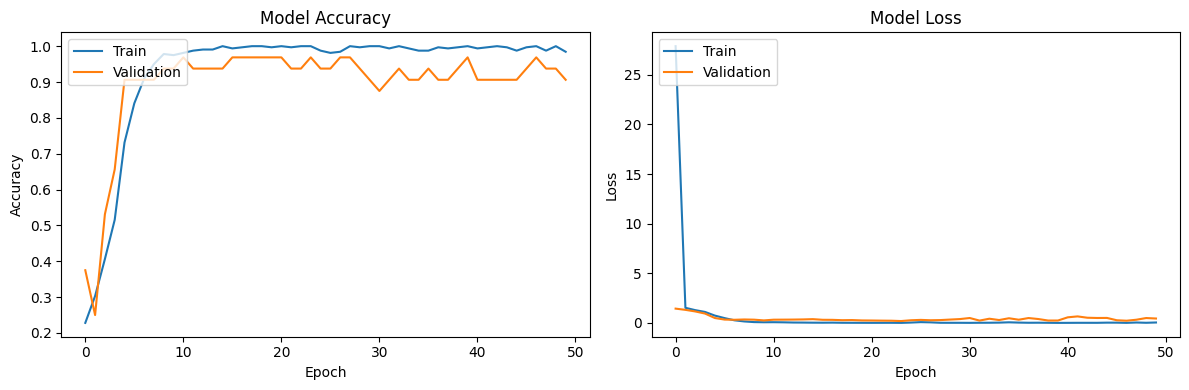

2/2 [==============================] - 0s 8ms/step - loss: 0.2995 - accuracy: 0.9375


In [59]:
# Plot training and validation accuracy curves
plt.figure(figsize=(12, 4))
# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

end_time = time.time()
training_time = end_time - start_time
# 打印模型概要
best_model = keras.models.load_model(checkpoint_filepath)
# 在测试集上评估模型
test_loss, _ = best_model.evaluate(test_ds)

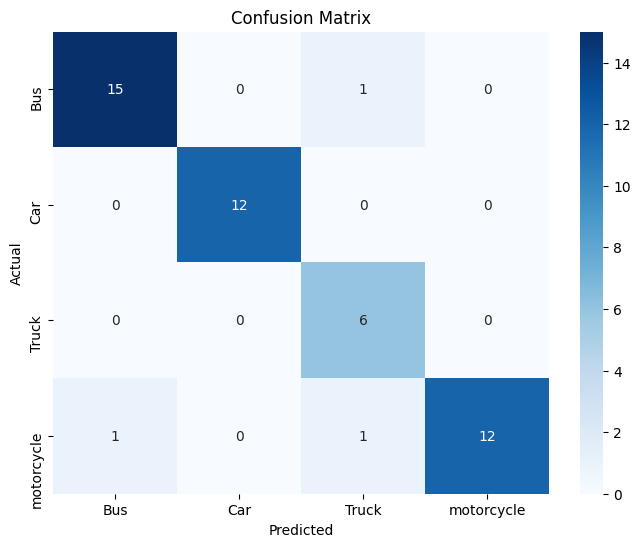

In [60]:
# 获取测试集的真实标签和预测标签
true_labels = []
predicted_labels = []
predicted_probs = []
for images, labels in test_ds:
    predictions = best_model.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))
    predicted_probs.extend(predictions)
    true_labels.extend(labels.numpy())

# 计算混淆矩阵
conf_mat = confusion_matrix(true_labels, predicted_labels)

# 使用Seaborn绘制混淆矩阵热力图
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=ds.class_names, yticklabels=ds.class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

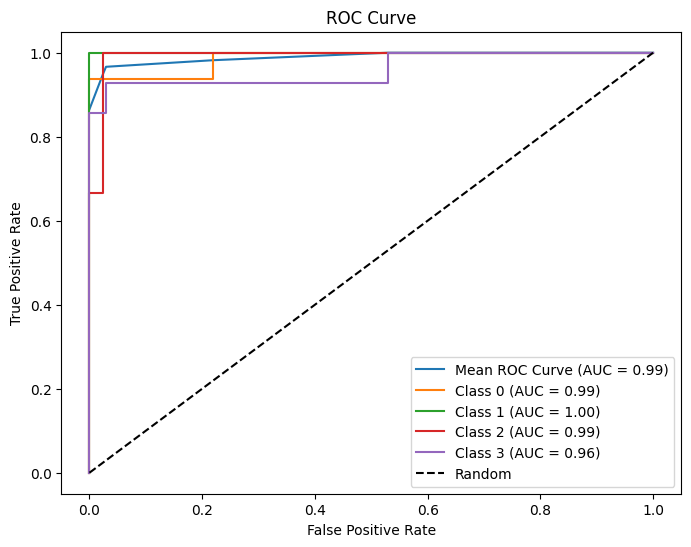

In [61]:
# Convert true labels to one-hot encoding for AUC calculation
true_labels_one_hot = tf.keras.utils.to_categorical(true_labels, num_classes=4)

# Convert predicted_probs to NumPy array
predicted_probs = np.array(predicted_probs)

# Calculate ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(true_labels_one_hot[:, i], predicted_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Calculate the average ROC curve
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(4)]))

# Interpolate ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(4):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Average and compute AUC
mean_tpr /= 4
mean_roc_auc = auc(all_fpr, mean_tpr)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(all_fpr, mean_tpr, label=f'Mean ROC Curve (AUC = {mean_roc_auc:.2f})')
for i in range(4):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

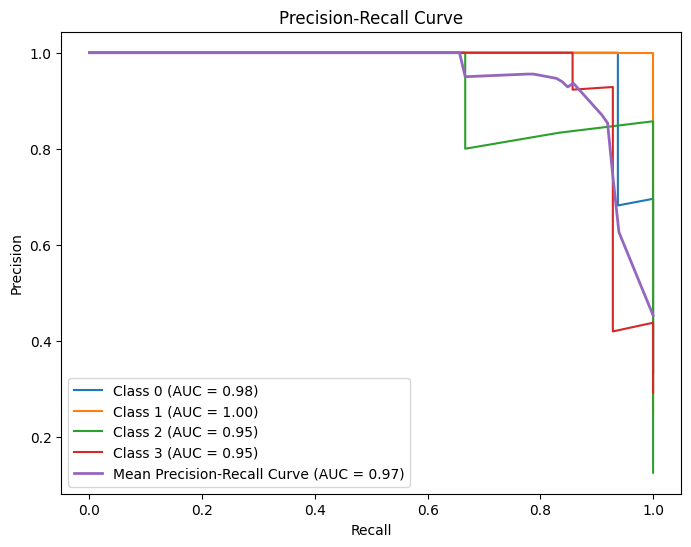

In [62]:
# Calculate precision-recall curve and AUC for each class
precision = dict()
recall = dict()
pr_auc = dict()

for i in range(4):
    precision[i], recall[i], _ = precision_recall_curve(true_labels_one_hot[:, i], predicted_probs[:, i])
    pr_auc[i] = average_precision_score(true_labels_one_hot[:, i], predicted_probs[:, i])

# Calculate the average precision-recall curve
# Calculate the average precision-recall curve
all_recall = np.linspace(0, 1, 100)
mean_precision = np.zeros_like(all_recall)
for i in range(4):
    # Interpolate precision values to have the same length
    interp_precision = interp1d(recall[i], precision[i], kind='linear', fill_value='extrapolate')
    interp_precision_values = interp_precision(all_recall)
    mean_precision += interp_precision_values

# Average and compute AUC
mean_precision /= 4
mean_pr_auc = average_precision_score(true_labels_one_hot, predicted_probs)


# Plot precision-recall curves
plt.figure(figsize=(8, 6))
for i in range(4):
    plt.plot(recall[i], precision[i], label=f'Class {i} (AUC = {pr_auc[i]:.2f})')
plt.plot(all_recall, mean_precision, label=f'Mean Precision-Recall Curve (AUC = {mean_pr_auc:.2f})', linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

In [63]:
# Calculate additional metrics
roc_auc = np.mean(list(roc_auc.values()))
pr_auc = np.mean(list(pr_auc.values()))
report = classification_report(true_labels, predicted_labels)
test_accuracy= custom_accuracy(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')
conf_mat = confusion_matrix(true_labels, predicted_labels)
# Calculate sensitivity and specificity for each class
class_sensitivity = []
class_specificity = []
for i in range(conf_mat.shape[0]):
    tp = conf_mat[i, i]  # True Positive
    tn = np.sum(np.delete(np.delete(conf_mat, i, axis=0), i, axis=1))  # True Negative
    fp = np.sum(conf_mat[:, i]) - tp  # False Positive
    fn = np.sum(conf_mat[i, :]) - tp  # False Negative

    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    class_sensitivity.append(sensitivity)
    class_specificity.append(specificity)

# Calculate macro-average sensitivity and specificity
macro_sensitivity = np.mean(class_sensitivity)
macro_specificity = np.mean(class_specificity)


# Print the metrics
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy*100:.2f}%')
print(f"Training time: {training_time:.2f} seconds")
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')
print(f'roc_auc: {roc_auc:.4f}')
print(f'pr_auc: {pr_auc:.4f}')
print('Confusion Matrix:')
print(conf_mat)
print(f'Sensitivity: {macro_sensitivity:.4f}')
print(f'Specificity: {macro_specificity:.4f}')
print(report)

Test Loss: 0.2995
Test Accuracy: 93.75%
Training time: 12.22 seconds
Precision: 0.9479
Recall: 0.9375
F1-Score: 0.9389
roc_auc: 0.9846
pr_auc: 0.9710
Confusion Matrix:
[[15  0  1  0]
 [ 0 12  0  0]
 [ 0  0  6  0]
 [ 1  0  1 12]]
Sensitivity: 0.9487
Specificity: 0.9803
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        16
           1       1.00      1.00      1.00        12
           2       0.75      1.00      0.86         6
           3       1.00      0.86      0.92        14

    accuracy                           0.94        48
   macro avg       0.92      0.95      0.93        48
weighted avg       0.95      0.94      0.94        48

